<a href="https://colab.research.google.com/github/lopezd16/Equipo4_proyecto_integrador/blob/main/Avance1_Equipo4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RADAR Predictivo — Notebook estructurado (NewsAPI + CoinGecko)

## Estructura de datos.

### NEWS_API:
News API es una API REST que permite acceder a noticias de miles de fuentes y blogs de todo el mundo en tiempo real. Proporciona funcionalidades como:

Búsqueda de titulares recientes por palabra clave, fuente, categoría o idioma

Acceso a artículos completos, títulos y metadatos

Filtro por fecha, popularidad o relevancia

Es útil para construir aplicaciones de agregación de noticias, análisis de medios o seguimiento de temas.

Requiere una API key gratuita (con límites) o de pago para mayor uso.

Sitio oficial: https://newsapi.org

Documentación: https://newsapi.org/docs

### Coin geko:
CoinGecko API es una API pública y gratuita (con planes premium) que permite acceder a datos actualizados del mercado de criptomonedas. Proporciona información como:

Precios en tiempo real de miles de criptomonedas

Volumen de comercio, capitalización de mercado

Historial de precios y gráficas

Información sobre exchanges, tokens, NFT, y más

No requiere autenticación para la mayoría de los endpoints públicos, lo que la hace ideal para prototipos y proyectos personales.

Sitio oficial: https://www.coingecko.com/en/api

Documentación: https://www.coingecko.com/en/api/documentation

In [ ]:
import os
import re
import time
import json
import math
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime, timezone

CONFIGURACIÓN GENERAL DEL PROYECTO

In [ ]:
NEWSAPI_KEY   = os.getenv("NEWSAPI_KEY", "62c474fdc3c64afeb4b41290b67b5b6f")
NEWS_QUERY    = "crypto"   # puedes probar también: "bitcoin", "ethereum", "defi", etc.
NEWS_LANG     = "en"       # "en" o "es" (corre el bloque dos veces si quieres combinar)
NEWS_PAGESIZE = 100
NEWS_SORT     = "popularity"   # relevancy|popularity|publishedAt
BASE_TODAY = date.today() - timedelta(days=1)
NEWS_FROM     = (BASE_TODAY - timedelta(days=1)).strftime("%Y-%m-%d")            # ej. "2025-08-31"
NEWS_TO       = BASE_TODAY.strftime("%Y-%m-%d")              # ej. "2025-09-01"

COINGECKO_MARKETS_URL    = "https://api.coingecko.com/api/v3/coins/markets"
COINGECKO_CATEGORIES_URL = "https://api.coingecko.com/api/v3/coins/categories"
VS_CURRENCY       = "usd"
MARKETS_PER_PAGE  = 100
MARKETS_PAGES     = 1          # aumenta si quieres >100 activos

OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

UTILIDADES DE LIMPIEZA Y NORMALIZACIÓN (PLN/NLP)

In [ ]:
URL_PATTERN      = re.compile(r"http\S+|www\.\S+")
HTML_TAG_PATTERN = re.compile(r"<.*?>")

def clean_text(txt: str) -> str:
    """
    Limpieza de texto para noticias:
      - Quita HTML y URLs.
      - Conserva caracteres alfanuméricos básicos, acentos y puntuación simple.
      - Normaliza espacios.
    """
    if not isinstance(txt, str):
        return ""
    txt = re.sub(HTML_TAG_PATTERN, " ", txt)
    txt = re.sub(URL_PATTERN, " ", txt)
    txt = re.sub(r"[^A-Za-z0-9ÁÉÍÓÚáéíóúñÑ .,!?()\-:;%/]", " ", txt)
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt

def normalize_symbol(sym: str, max_len: int = 5) -> str:
    """
    Normaliza el símbolo de la cripto:
      - Solo letras (sin números/guiones).
      - Mayúsculas.
      - Longitud máxima = 5 (ej. BTC, ETH, SOL).
    """
    if not isinstance(sym, str):
        return ""
    sym = re.sub(r"[^A-Za-z]", "", sym).upper()
    return sym[:max_len]

def split_datetime_iso8601(ts: str):
    """
    Convierte una marca de tiempo ISO8601 a:
      (fecha_dd/mm/yyyy, hora_HH:MM:SS).
    Soporta sufijo 'Z' y offsets.
    """
    if not isinstance(ts, str) or not ts:
        return "", ""
    try:
        dt = datetime.fromisoformat(ts.replace("Z", "+00:00"))
        return dt.strftime("%d/%m/%Y"), dt.strftime("%H:%M:%S")
    except Exception:
        return "", ""

DESCARGA DE DATOS DESDE LAS TRES FUENTES

In [ ]:
def fetch_newsapi(query=NEWS_QUERY, language=NEWS_LANG, pagesize=NEWS_PAGESIZE,
                  sortby=NEWS_SORT, api_key=NEWSAPI_KEY, from_date=NEWS_FROM, to_date=NEWS_TO, page=1):
    """
    Descarga noticias desde NewsAPI. Si no hay API key, devuelve un lote DEMO.
    """
    if api_key == "YOUR_NEWSAPI_KEY" or not api_key:
        return {
            "status": "ok",
            "totalResults": 3,
            "articles": [
                {
                    "source": {"id": "business-insider", "name": "Business Insider"},
                    "author": "Henry Chandonnet",
                    "title": "Marc Benioff on AGI 'hypnosis' – what it means for crypto markets",
                    "description": "Salesforce CEO doubts AGI hype. <b>Markets react</b>. Read more at https://example.com ...",
                    "url": "https://www.businessinsider.com/marc-benioff-extremely-suspect-agi-hypnosis-2025-8",
                    "urlToImage": "https://i.insider.com/img.jpg",
                    "publishedAt": "2025-08-28T18:12:29Z",
                    "content": "AGI hype & crypto: visit https://foo.bar for details. <ul><li>BTC up?</li></ul>"
                },
                {
                    "source": {"id": None, "name": "Reuters"},
                    "author": None,
                    "title": "ETF Bitcoin receives approval; volatility ahead?",
                    "description": "Regulators approve ETF. Markets brace for swings.",
                    "url": "https://www.reuters.com/markets/bitcoin-etf-approved-2025-08-28/",
                    "urlToImage": None,
                    "publishedAt": "2025-08-28T09:00:02Z",
                    "content": "Analysts expect higher inflows. Read at http://reuters.com/article?id=xyz."
                },
                {
                    "source": {"id": "ft", "name": "Financial Times"},
                    "author": "FT Staff",
                    "title": "DeFi growth accelerates in Latin America 🚀",
                    "description": "TVL climbs 15% this week; key protocols show strength.",
                    "url": "https://www.ft.com/content/defi-growth-latam",
                    "urlToImage": "https://www.ft.com/img.jpg",
                    "publishedAt": "2025-08-29T01:20:00Z",
                    "content": "DeFi momentum across ETH, SOL. <a href='https://ft.com/defi'>link</a>"
                },
            ]
        }
    url = "https://newsapi.org/v2/everything"
    params = {
        "q": query,
        "language": language,
        "pageSize": pagesize,
        "sortBy": sortby,
        "apiKey": api_key,
        "page": page
    }
    if from_date: params["from"] = from_date
    if to_date:   params["to"]   = to_date
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    return r.json()

def fetch_coingecko_markets(vs_currency=VS_CURRENCY, per_page=MARKETS_PER_PAGE, page=1):
    """
    Descarga el ranking de criptomonedas por market cap (hasta 'per_page' por página).
    """
    params = {
        "vs_currency": vs_currency,
        "order": "market_cap_desc",
        "per_page": per_page,
        "page": page,
        "sparkline": "false"
    }
    r = requests.get(COINGECKO_MARKETS_URL, params=params, timeout=30)
    r.raise_for_status()
    return r.json()

def fetch_coingecko_categories():
    """
    Descarga categorías (Layer1, DeFi, PoW, etc.) con market cap y top 3 coins por categoría.
    """
    r = requests.get(COINGECKO_CATEGORIES_URL, timeout=30)
    r.raise_for_status()
    return r.json()

# Ejecutar las 3 descargas
news_raw = fetch_newsapi()
mkts_raw = []
for p in range(1, MARKETS_PAGES + 1):
    mkts_raw.extend(fetch_coingecko_markets(page=p))
    time.sleep(1)  # cortesía para evitar rate limiting
cats_raw = fetch_coingecko_categories()

print(f"Noticias:    {len(news_raw.get('articles', []))}")
print(f"Markets:     {len(mkts_raw)}")
print(f"Categorías:  {len(cats_raw)}")

Noticias:    100
Markets:     100
Categorías:  615


CONSTRUCCIÓN DE DATAFRAMES + LIMPIEZA APLICADA

In [ ]:
# --- Noticias ---
df_news = pd.DataFrame(news_raw.get("articles", []))

# Aplanamos la fuente: dict -> string
if "source" in df_news.columns:
    df_news["source_name"] = df_news["source"].apply(lambda s: s.get("name") if isinstance(s, dict) else None)

# Limpieza de textos (title, description, content)
for col in ["title", "description", "content"]:
    df_news[col + "_clean"] = df_news[col].apply(clean_text)

# Autor nulo -> "Desconocido"
df_news["author"] = df_news["author"].fillna("Desconocido")

# Separar fecha/hora (ISO8601 -> dd/mm/yyyy + HH:MM:SS)
df_news[["fecha", "hora"]] = df_news["publishedAt"].apply(lambda x: pd.Series(split_datetime_iso8601(x)))

# Selección/renombrado de columnas finales
df_news_clean = df_news[[
    "source_name", "author", "title_clean", "description_clean", "content_clean", "fecha", "hora", "url"
]].rename(columns={
    "source_name": "fuente",
    "title_clean": "titulo",
    "description_clean": "descripcion",
    "content_clean": "contenido"
})

# --- Mercados (CoinGecko) ---
df_markets = pd.DataFrame(mkts_raw)

if not df_markets.empty:
    # Normalizar símbolo
    df_markets["symbol"] = df_markets["symbol"].apply(normalize_symbol)
    # Transformación logarítmica para market_cap (reduce dispersión)
    if "market_cap" in df_markets.columns:
        df_markets["log_market_cap"] = np.log1p(df_markets["market_cap"].astype(float))
    # Separar fecha/hora
    if "last_updated" in df_markets.columns:
        df_markets[["fecha", "hora"]] = df_markets["last_updated"].apply(lambda x: pd.Series(split_datetime_iso8601(x)))

df_crypto_clean = df_markets[[
    "id","name","symbol","current_price","market_cap","total_volume",
    "price_change_percentage_24h","log_market_cap","fecha","hora"
]].rename(columns={"name":"asset"})

# --- Categorías (CoinGecko) ---
df_categories = pd.DataFrame(cats_raw)
sel_cols = ["id","name","market_cap","market_cap_change_24h","volume_24h","top_3_coins_id","updated_at"]
df_categories = df_categories[[c for c in sel_cols if c in df_categories.columns]]

if "updated_at" in df_categories.columns:
    df_categories[["fecha","hora"]] = df_categories["updated_at"].apply(lambda x: pd.Series(split_datetime_iso8601(x)))
    df_categories = df_categories.drop(columns=["updated_at"])

df_categories = df_categories.rename(columns={"name":"category"})

GUARDADO DE VERSIONES LIMPIAS (CSV PARCIALES)

In [ ]:
news_path  = os.path.join(OUTPUT_DIR, "news_clean.csv")
crypto_path= os.path.join(OUTPUT_DIR, "crypto_clean.csv")
cats_path  = os.path.join(OUTPUT_DIR, "categories_clean.csv")

df_news_clean.to_csv(news_path, index=False)
df_crypto_clean.to_csv(crypto_path, index=False)
df_categories.to_csv(cats_path, index=False)

print("Guardados:", news_path, crypto_path, cats_path)

Guardados: outputs/news_clean.csv outputs/crypto_clean.csv outputs/categories_clean.csv


EDA GUIADO (PREGUNTAS FRECUENTES DE LA GUÍA)

===== ¿Hay valores faltantes? ¿Patrones de ausencia? =====

--- Nulos por columna (news_clean) ---
Series([], dtype: int64)
Total filas: 100

--- Nulos por columna (crypto_clean) ---
Series([], dtype: int64)
Total filas: 100

--- Nulos por columna (categories_clean) ---
market_cap_change_24h    284
market_cap               284
volume_24h               284
dtype: int64
Total filas: 615


===== ¿Cuáles son las estadísticas resumidas? =====

**** Estadísticas (numéricas) :: crypto_clean ****
                             count          mean           std           min  \
current_price                100.0  4.921873e+03  2.153198e+04  9.200000e-06   
market_cap                   100.0  3.845972e+10  2.235138e+11  1.346934e+09   
total_volume                 100.0  3.699887e+09  1.745187e+10  0.000000e+00   
price_change_percentage_24h  100.0 -2.190790e+00  3.909093e+00 -2.598129e+01   
log_market_cap               100.0  2.233476e+01  1.365811e+00  2.102110e+01   

                         

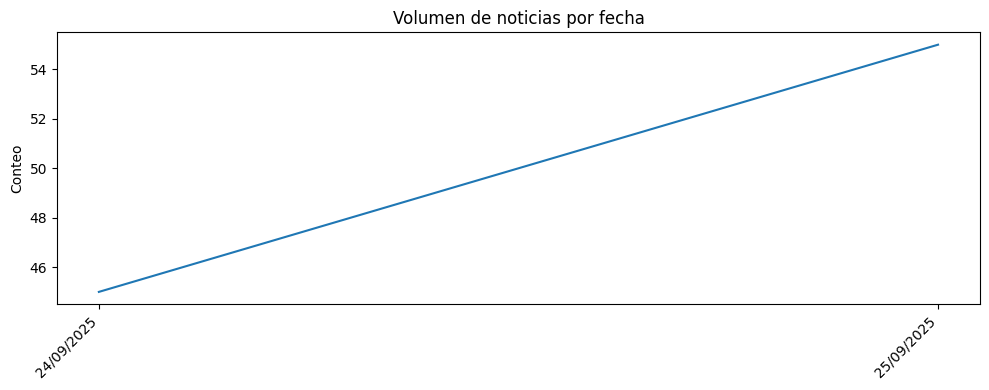



===== ¿Hay correlación entre variables? (solo numéricas de mercados) =====

Matriz de correlación (cripto - numéricas):
                             current_price  market_cap  total_volume  \
current_price                        1.000       0.473         0.164   
market_cap                           0.473       1.000         0.506   
total_volume                         0.164       0.506         1.000   
price_change_percentage_24h          0.017       0.009         0.058   
log_market_cap                       0.240       0.593         0.581   

                             price_change_percentage_24h  log_market_cap  
current_price                                      0.017           0.240  
market_cap                                         0.009           0.593  
total_volume                                       0.058           0.581  
price_change_percentage_24h                        1.000           0.087  
log_market_cap                                     0.087           1.0

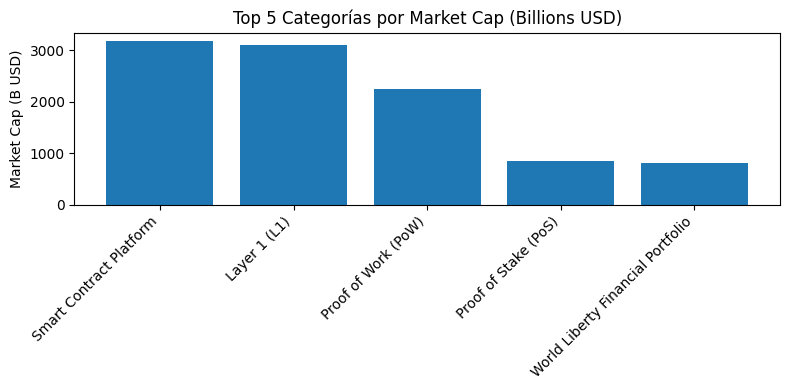



===== ¿Se requieren normalizaciones para visualizar/mejorar modelos? =====

Sugerencia: aplicar normalización/estandarización (rangos muy dispares).
Rangos observados: {'current_price': 109766.9999908, 'market_cap': 2182314552743.0, 'total_volume': 149948845579.0}


===== ¿Hay desequilibrio en la variable objetivo? =====

[Info] Aún no existe columna 'sentiment'. Se evaluará el balanceo tras el etiquetado (neg/neu/pos).


In [ ]:
# 5.1) ¿Hay valores faltantes? ¿Patrones de ausencia?
print("===== ¿Hay valores faltantes? ¿Patrones de ausencia? =====")
def resumen_nulos(df, nombre):
    print(f"\n--- Nulos por columna ({nombre}) ---")
    nulos = df.isna().sum().sort_values(ascending=False)
    print(nulos[nulos > 0])
    print("Total filas:", len(df))

resumen_nulos(df_news_clean,   "news_clean")
resumen_nulos(df_crypto_clean, "crypto_clean")
resumen_nulos(df_categories,   "categories_clean")

# 5.2) ¿Cuáles son las estadísticas resumidas?
print("\n\n===== ¿Cuáles son las estadísticas resumidas? =====")
def stats_resumidas(df, nombre):
    print(f"\n**** Estadísticas (numéricas) :: {nombre} ****")
    print(df.select_dtypes(include=[np.number]).describe().T)

stats_resumidas(df_crypto_clean, "crypto_clean")
stats_resumidas(df_categories,   "categories_clean")

# 5.3) ¿Hay valores atípicos? (IQR rule para numéricos clave)
print("\n\n===== ¿Hay valores atípicos? (IQR rule para numéricos clave) =====")
def detectar_outliers_iqr(serie: pd.Series, k: float = 1.5):
    q1, q3 = serie.quantile(0.25), serie.quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - k*iqr, q3 + k*iqr
    mask = (serie < low) | (serie > high)
    return mask, (low, high)

for col in ["current_price", "market_cap", "total_volume", "price_change_percentage_24h"]:
    if col in df_crypto_clean.columns:
        mask, (low, high) = detectar_outliers_iqr(df_crypto_clean[col].dropna())
        print(f"\nOutliers en {col}: {mask.sum()} / {len(df_crypto_clean)} (rango permitido [{low:.2f}, {high:.2f}])")

# 5.4) ¿Cuál es la cardinalidad de variables categóricas?
print("\n\n===== ¿Cuál es la cardinalidad de variables categóricas? =====")
def cardinalidades(df, cols, nombre):
    print(f"\n**** Cardinalidad :: {nombre} ****")
    for c in cols:
        if c in df.columns:
            print(f"{c:>20s}: {df[c].nunique()} valores únicos")

cardinalidades(df_news_clean,   ["fuente"], "news_clean")
cardinalidades(df_crypto_clean, ["symbol","asset"], "crypto_clean")
cardinalidades(df_categories,   ["category"], "categories_clean")

# 5.5) ¿Existen distribuciones sesgadas? (skewness) y ¿tendencias temporales?
print("\n\n===== ¿Existen distribuciones sesgadas? (skewness) y ¿tendencias temporales? =====")
def skewness_cols(df, nombre):
    print(f"\n**** Asimetría (skew) :: {nombre} ****")
    for c in df.select_dtypes(include=[np.number]).columns:
        print(f"{c:>28s}: {df[c].dropna().skew():.3f}")

skewness_cols(df_crypto_clean, "crypto_clean")
skewness_cols(df_categories,   "categories_clean")

# Tendencia temporal (conteo de noticias por fecha)
if "fecha" in df_news_clean.columns:
    noticias_por_dia = df_news_clean.groupby("fecha").size().sort_index()
    print("\nNoticias por fecha (ultimas 15):")
    print(noticias_por_dia.tail(15))

    plt.figure(figsize=(10,4))
    plt.plot(noticias_por_dia.index, noticias_por_dia.values)
    plt.xticks(rotation=45, ha="right")
    plt.title("Volumen de noticias por fecha")
    plt.ylabel("Conteo")
    plt.tight_layout()
    plt.show()

# 5.6) ¿Hay correlación entre variables? (solo numéricas de mercados)
print("\n\n===== ¿Hay correlación entre variables? (solo numéricas de mercados) =====")
if not df_crypto_clean.empty:
    corr = df_crypto_clean.select_dtypes(include=[np.number]).corr()
    print("\nMatriz de correlación (cripto - numéricas):")
    print(corr.round(3))

# 5.7) ¿Cómo se distribuyen los datos por categorías? (análisis bivariado)
print("\n\n===== ¿Cómo se distribuyen los datos por categorías? (análisis bivariado) =====")
#     Ejemplo: top categorías por market cap
if not df_categories.empty and "market_cap" in df_categories.columns:
    top5_cat = df_categories.nlargest(5, "market_cap")[["category","market_cap"]]
    print("\nTop 5 categorías por market cap:")
    print(top5_cat)

    plt.figure(figsize=(8,4))
    plt.bar(top5_cat["category"], top5_cat["market_cap"]/1e9)
    plt.xticks(rotation=45, ha="right")
    plt.title("Top 5 Categorías por Market Cap (Billions USD)")
    plt.ylabel("Market Cap (B USD)")
    plt.tight_layout()
    plt.show()

# 5.8) ¿Se requieren normalizaciones para visualizar/mejorar modelos?
print("\n\n===== ¿Se requieren normalizaciones para visualizar/mejorar modelos? =====")
#     Heurística: comparar rangos; si difieren varios órdenes de magnitud, sugerir escalar.
def sugerir_normalizacion(df, cols):
    rangos = {}
    for c in cols:
        if c in df.columns:
            s = df[c].dropna().astype(float)
            if len(s):
                rangos[c] = s.max() - s.min()
    if rangos:
        max_r = max(rangos.values())
        min_r = min(rangos.values())
        if min_r > 0 and (max_r / min_r) > 1e3:
            print("\nSugerencia: aplicar normalización/estandarización (rangos muy dispares).")
        else:
            print("\nRangos comparables: normalización no crítica para visualización simple.")
        print("Rangos observados:", {k: float(v) for k, v in rangos.items()})

sugerir_normalizacion(df_crypto_clean, ["current_price","market_cap","total_volume"])

# 5.9) ¿Hay desequilibrio en la variable objetivo?
print("\n\n===== ¿Hay desequilibrio en la variable objetivo? =====")
#     En esta etapa aún no etiquetamos sentimiento; mostramos cómo checarlo si existe.
if "sentiment" in df_news_clean.columns:
    print("\nDistribución de la variable objetivo (sentiment):")
    print(df_news_clean["sentiment"].value_counts(dropna=False))
else:
    print("\n[Info] Aún no existe columna 'sentiment'. Se evaluará el balanceo tras el etiquetado (neg/neu/pos).")


VISTAS RÁPIDAS PARA EL REPORTE (GRÁFICOS SENCILLOS)

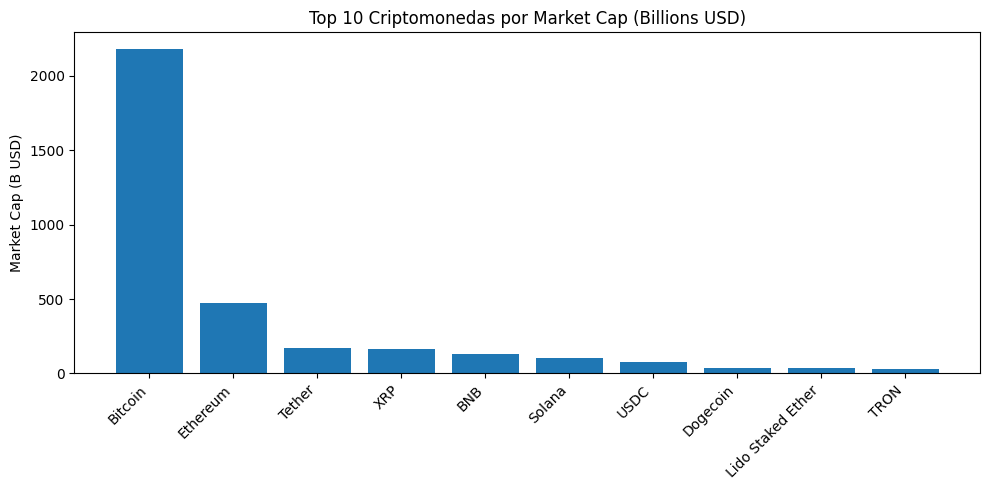

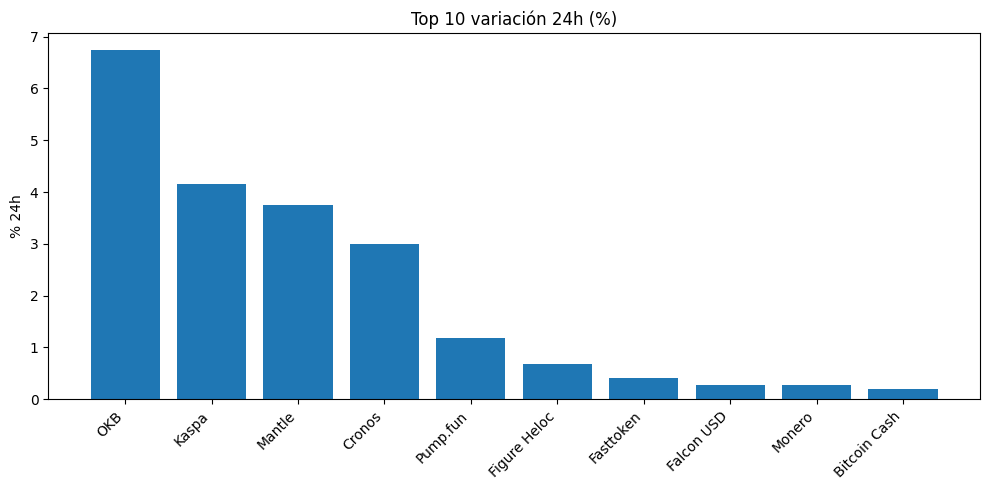

In [ ]:
if not df_crypto_clean.empty:
    # Top 10 por market cap
    top10 = df_crypto_clean.nlargest(10, "market_cap")
    plt.figure(figsize=(10,5))
    plt.bar(top10["asset"], top10["market_cap"]/1e9)
    plt.title("Top 10 Criptomonedas por Market Cap (Billions USD)")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Market Cap (B USD)")
    plt.tight_layout()
    plt.show()

    # Mayores variaciones positivas 24h
    movers = df_crypto_clean.nlargest(10, "price_change_percentage_24h")
    plt.figure(figsize=(10,5))
    plt.bar(movers["asset"], movers["price_change_percentage_24h"])
    plt.title("Top 10 variación 24h (%)")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("% 24h")
    plt.tight_layout()
    plt.show()

## Conclusiones

 

### Basado en el análisis exploratorio de datos, aquí hay algunas conclusiones clave:

#### Valores Faltantes:
df_news_clean y df_crypto_clean no tienen valores faltantes.
df_categories tiene valores faltantes en market_cap, market_cap_change_24h y volume_24h.

#### Estadísticas Resumidas:
df_crypto_clean muestra un amplio rango en los valores numéricos, con market_cap teniendo la media y desviación estándar más altas, lo que sugiere la presencia de algunas criptomonedas dominantes.
df_categories también muestra un amplio rango en los valores numéricos para market_cap y volume_24h.

#### Valores Atípicos (Outliers):
Se detectaron valores atípicos en current_price, market_cap, total_volume y price_change_percentage_24h en el dataframe df_crypto_clean, lo cual es esperado en datos financieros con grandes variaciones.

#### Cardinalidad:
La columna fuente en df_news_clean tiene 22 valores únicos.
El dataframe crypto_clean tiene 98 símbolos únicos y 100 nombres de activos únicos.
El dataframe categories_clean tiene 615 categorías únicas.

#### Asimetría (Skewness) y Tendencias Temporales:
Las columnas numéricas en df_crypto_clean y df_categories muestran alta asimetría, lo que indica que la mayoría de los valores se concentran en el extremo inferior con algunos valores muy grandes (consistente con la presencia de valores atípicos y activos/categorías dominantes).
La tendencia temporal del volumen de noticias muestra un ligero aumento en el número de artículos del 24/09/2025 al 25/09/2025.

#### Correlaciones:
En df_crypto_clean, market_cap y total_volume muestran una correlación positiva moderada (0.506), y log_market_cap tiene una correlación positiva moderada con market_cap y total_volume (0.593 y 0.581 respectivamente). current_price tiene una correlación positiva débil con market_cap (0.473) y total_volume (0.164).

#### Distribución por Categorías:
Las 5 categorías principales por capitalización de mercado son "Smart Contract Platform", "Layer 1 (L1)", "Proof of Work (PoW)", "Proof of Stake (PoS)" y "World Liberty Financial Portfolio", destacando el dominio de las tecnologías blockchain fundamentales y los grandes ecosistemas.

#### Normalización:
Se sugiere aplicar normalización o estandarización a las columnas numéricas en df_crypto_clean debido a las grandes diferencias en sus rangos, lo que podría ser beneficioso para ciertos modelos o visualizaciones.

#### Desbalanceo de la Variable Objetivo:
El análisis señala que la columna 'sentiment' aún no existe, y el balance de clases deberá verificarse después de realizar el etiquetado de sentimiento.